In [1]:
#@title Some helper functions
%%capture
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
import torch, torchvision
import sys

sys.setrecursionlimit(2000) #prevents infinite recursion

def generate_dataset(n_data, n_cluster=2, n_dim=2, ax=None):
    n_data //= n_cluster
    cent = np.arange(n_dim*n_cluster)
    np.random.shuffle(cent)
    cent = cent.reshape(1, n_cluster, n_dim)

    X = np.random.randn(n_data, n_cluster, n_dim)/1.5 + cent
    if ax and n_dim == 2:
        for i in range(n_cluster):
            ax.scatter(*X[..., i, :].transpose((-1, 0)).reshape(2, -1))
    return X.reshape(-1, n_dim)

def plot_kmean_trajectory(k_means, X):
    from sklearn.inspection import DecisionBoundaryDisplay

    feature_1, feature_2 = np.meshgrid(
        np.linspace(X[:, 0].min()-0.2, X[:, 0].max()+0.2, num=100),
        np.linspace(X[:, 1].min()-0.2, X[:, 1].max()+0.2, num=100)
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    dist = np.linalg.norm(
        np.expand_dims(grid, 1) - k_means, axis=-1
    )
    ct = np.argmin(dist, axis=-1).reshape(feature_1.shape)
    display = DecisionBoundaryDisplay(
        xx0=feature_1, xx1=feature_2, response=ct
    )
    display.plot()

    dist = np.linalg.norm(
        np.expand_dims(X, 1) - k_means, axis=-1
    )
    y_pred = np.argmin(dist, axis=-1).reshape(-1)
    display.ax_.scatter(
        *X.T, edgecolor="black", c=y_pred
    )
    plt.show()

def plot_dbscan(core, border, noise, neighbor, X, dsu):
    for core_i in np.unique(dsu[core]):
        plt.scatter(*X[(dsu==core_i) * core].T, edgecolor="black")
    plt.gca().set_prop_cycle(None)
    for border_i in np.unique(dsu[core]):
        plt.scatter(*X[(dsu==border_i)*border].T,
                    alpha=0.3, edgecolor="black")
    for border_i in set(np.unique(dsu[border])) - set(np.unique(dsu[core])):
        plt.scatter(*X[(dsu==border_i)*border].T,
                    alpha=0.3, edgecolor="black")
    plt.scatter(*X[noise].T, alpha=0.3, label="noise", c='black', marker="D")
    plt.title("DBSCAN")
    plt.legend()
    plt.show()

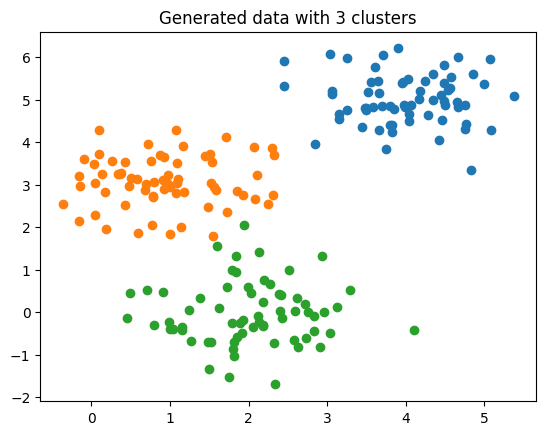

In [2]:
fig, ax = plt.subplots()
X = generate_dataset(200, 3, ax=ax)
plt.title("Generated data with 3 clusters")
plt.show()

# K-Means Clustering
In K mean, we maintain a set of k centroid (initially random data points). Then the algorithm repeats until (hopefully) convergence. At each iteration, all the datapoints in the dataset are grouped into the cluster whose centroid is closest to them. Then the newly calculated clusters are used to update the k centroids.

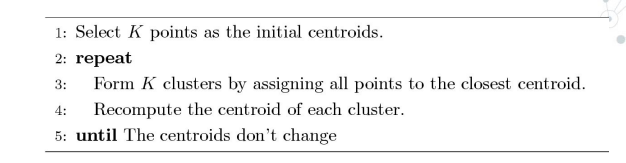

(1, 3, 2) (198, 2)


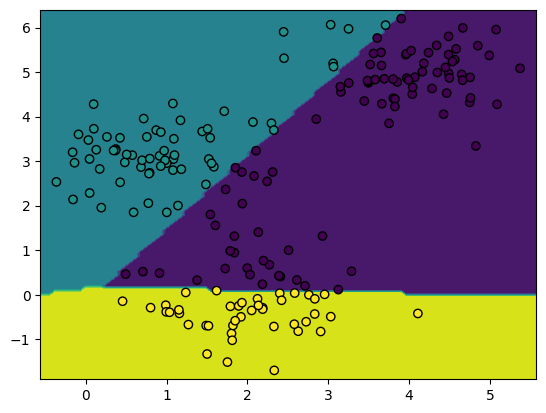

In [3]:
n_cluster = 3
n_dim = 2
iter = 1000

k_means = np.array([random.choices(X, k=n_cluster)] ) # random init
print(k_means.shape, X.shape)
plot_kmean_trajectory(k_means, X)

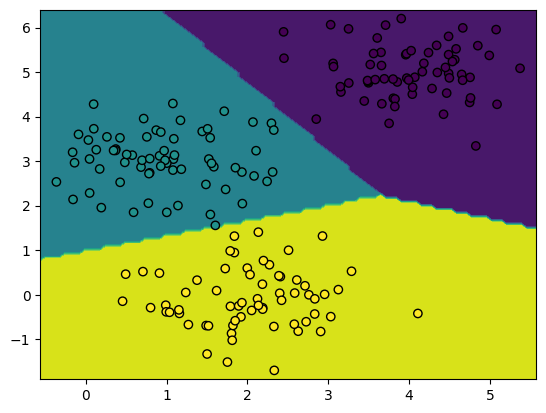

In [4]:
#@title K-Means Implementation {vertical-output: false}

for _ in range(iter):
    dist = np.linalg.norm(
        np.expand_dims(X, 1) - k_means, axis=-1
    )
    cluster = np.argmin(dist, axis=-1) # assign to cluster
    for c in range(n_cluster): # recompute centroid each cluster
        k_means[:,c] = np.mean(X[cluster == c], axis=0)

plot_kmean_trajectory(k_means, X)

/usr/local/lib/python3.10/dist-packages/sklearn/inspection/_plot/decision_boundary.py:191: UserWarning: The following kwargs were not used by contour: 'lpha'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


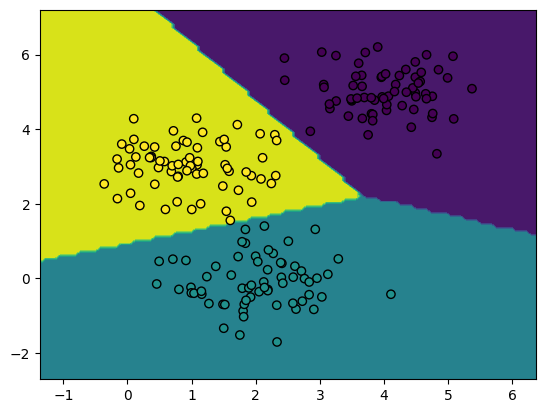

In [5]:
#@title K-Means Sklearn {vertical-output: false}
from sklearn.cluster import KMeans
from sklearn.inspection import DecisionBoundaryDisplay

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X)
disp = DecisionBoundaryDisplay.from_estimator(
    kmeans, X, response_method="predict",
    lpha=0.5,
)
disp.ax_.scatter(X[:, 0], X[:, 1], c=kmeans.predict(X), edgecolor="k")
plt.show();

# DBSCAN

In [6]:
#@title Noisy circle dataset {vertical-output: true}
from sklearn import datasets
n_samples = 2000
seed = 30

X, y = datasets.make_circles(
    n_samples=n_samples, factor=.5, noise=0.09, random_state=seed
)

In DBSCAN, there are three types of points: core points, border points and noise points. Core points are points that has at least `min_samples` neighbors (or degree). Border points are points that are not core points but connect to at least a core point. And Noise points are points that are neither core nor border.

*Note*: two points are connected (or be neighbor of each other) if their distance are less than `eps`. As such, `eps` and `min_samples` are two most important hyper-parameters to consider when using DBSCAN.

After finding which points are core. DBSCAN connects core points to form connected components, which will be clusters. For finding connected components, we use DSU algorithm.

The complexity of the algorithm will depend on two critical operations: finding neighbors and connecting core points. In the below implementation, we use brute force approach: all distance pairs are calculated, which has complexity of $O(n^2)$. More efficient data structure can be used to facilitate the search for nearest neighbors, such as kd tree. In sklearn, there is a hyperparameter that specifies which data structure to be used for finding neighbors (see `algorithm`). For DSU, efficient implementation has complexity of $O(n\alpha (n))$ with $\alpha(n)$ is the inverse Ackermann function, while the DSU implementation below has complexity of $O(n\log n)$. You can see this [link](https://cp-algorithms.com/data_structures/disjoint_set_union.html) for more information about DSU.

In [7]:
#@title DBSCAN implementation
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def dbscan(X, eps, min_samples):
    labels = np.zeros(X.shape[0])  # Khởi tạo nhãn, 0 cho noise

    # Gán nhãn cho các điểm cốt lõi (core points)
    cluster_label = 0
    for i in range(X.shape[0]):
        if labels[i] != 0:  # Đã gán nhãn cho điểm này
            continue

        neighbors = find_neighbors(X, i, eps)
        if len(neighbors) < min_samples:
            labels[i] = -1  # Đánh dấu là noise
        else:
            cluster_label += 1
            labels[i] = cluster_label
            expand_cluster(X, labels, i, neighbors, cluster_label, eps, min_samples)

    return labels

def find_neighbors(X, center_index, eps):
    distances = euclidean_distances(X[center_index].reshape(1, -1), X).flatten()
    neighbors = np.where(distances <= eps)[0]
    return neighbors

def expand_cluster(X, labels, center_index, neighbors, cluster_label, eps, min_samples):
    for neighbor in neighbors:
        if labels[neighbor] == 0:  # Chưa được gán nhãn
            labels[neighbor] = cluster_label

            new_neighbors = find_neighbors(X, neighbor, eps)
            if len(new_neighbors) >= min_samples:
                neighbors = np.union1d(neighbors, new_neighbors)

# Tạo dữ liệu mẫu và triển khai DBSCAN
data = X
epsilon = 1.5
min_samples = 5

# Áp dụng DBSCAN
result_labels = dbscan(data, epsilon, min_samples)
print("Result Labels:", result_labels)


Result Labels: [1. 2. 1. ... 1. 1. 1.]


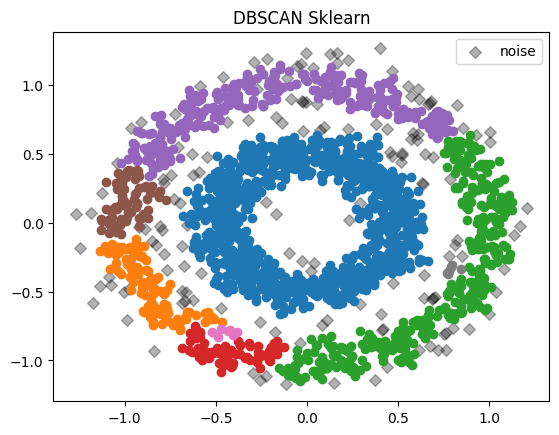

In [10]:
#@title DBSCAN Sklearn {vertical-output: true}
from sklearn.cluster import DBSCAN

eps = 6e-2
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
for i in np.unique(clustering.labels_.astype(int)):
    if i == -1:
        plt.scatter(*X[clustering.labels_ == i].T, label="noise",
                    c="black", alpha=0.3, marker="D")
    else:
        plt.scatter(*X[clustering.labels_ == i].T)
plt.title("DBSCAN Sklearn")
plt.legend()
plt.show()

In [ ]:
#@title DBSCAN Implementation (DSU structure) {vertical-output: false}

eps = 6e-2
min_samples = 3

dist = np.linalg.norm(
    np.expand_dims(X, 0) - np.expand_dims(X, 1), axis=-1
)

neighbor = dist < eps

# core points are points with > min_samples neighbor
core = neighbor.sum(axis=-1) > min_samples
# border points are points that connect to a core point and not a core point
border = (np.sum(neighbor * (np.ones(core[..., None].shape) @ core[..., None].T), axis=-1) > 0) ^ core
# noise points are points that are neither core nor border
noise = ~(border | core)

# DSU data structure for finding connected components
dsu = np.arange(X.shape[0])
def find_set(v):
    if v == dsu[v]:
        return v
    dsu[v] = find_set(dsu[v])
    return dsu[v]

def union_sets(a, b):
    a = find_set(a)
    b = find_set(b)
    if a != b:
        dsu[b] = a

# connect cores (both are core vertices and be neighbors of each other)
for c1, c2 in zip(*np.where((neighbor * (core[..., None] @ core[..., None].T)) == 1)):
    union_sets(c1, c2)

# connect borders to cores (one is core, one is border and are neighbors)
for b, c in zip(*np.where((neighbor * (border[..., None] @ core[..., None].T)) == 1)):
    dsu[b] = find_set(c)

# make dsu flat again :v
for i in range(X.shape[0]):
    dsu[i] = find_set(i)

plot_dbscan(core, border, noise, neighbor, X, dsu)